## Preprocess the Data for Dataset for YOLO Model

This is divided into 3 Chapters
- Chapter 1: transform a Radargramm into a image for a YOLO model
- Chapter 2: Create multiple images out of Our given Data
- Chapter 3: Normalize the Series of Images
- Chapter 4: Annotating/Labeling the Data

### Chapter 1: transform a Radargramm into a image for a YOLO model
trying to convert a Radargramm to an Image. **Pipeline/Datatoolkit** can be used to laod the data and create a DataFrame.

In [1]:
#Setting Working directory
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

#Import the config file so that only the Filename needs to be changed in the _read_segy function
from config import *

from Pipeline.Datatoolkit import DatatoolKit

dk1 = DatatoolKit(TEST_FILE_DIR,"UG3DQUERUNTERZUG.SGY")
dk2 = DatatoolKit(TEST_FILE_DIR,"EG-3D QUER001.SGY")


file1 = dk1.LoadSGY()
file2 = dk2.LoadSGY()


Next step is to create the Dataframes



In [2]:
df1 = dk1.create_df(file1)
df2 = dk2.create_df(file2)

##### Inline Plot

This is the same Plot as in the Notebook **Analyzing the Data**. It plots all crosslines according to one inline. This is one sphere so one cut threw the inline.

**please note that it is only one inline**

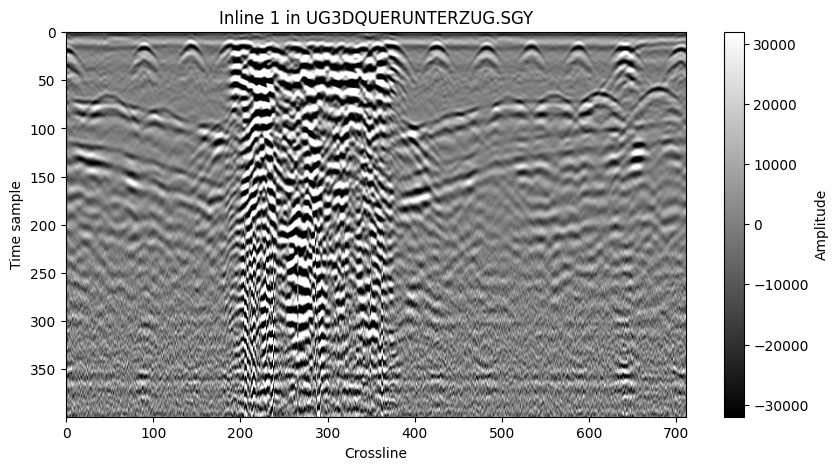

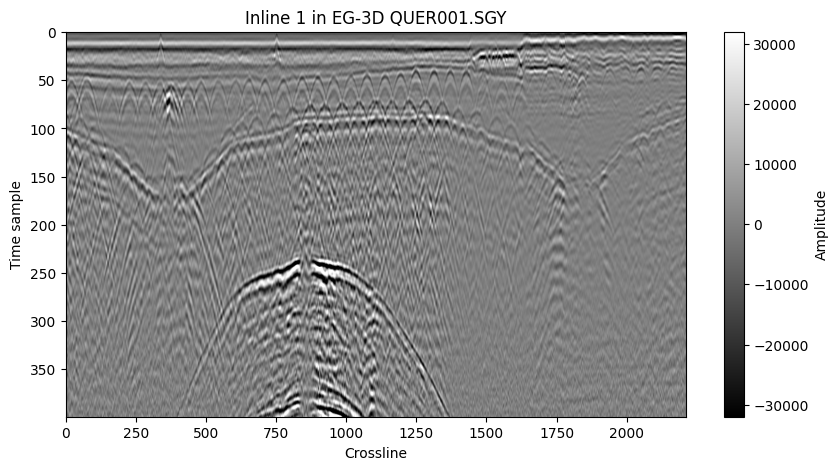

In [7]:
#function to plot crosslines on the x-axis and on the y-Axis the time samples
dk1.plot_inline_cut_raw(df1, 1)
dk2.plot_inline_cut_raw(df2, 1)

#### Crossline Plot

This is the same Plot as in the Notebook **Analyzing the Data**. this plots all inlines according to one crosslines. This is again one spher so one cut threw the crossllines

**please Note that it is only one Crossline**

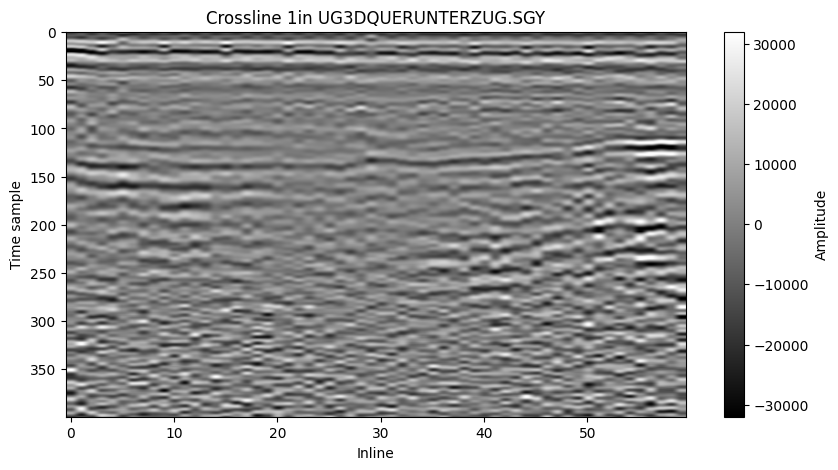

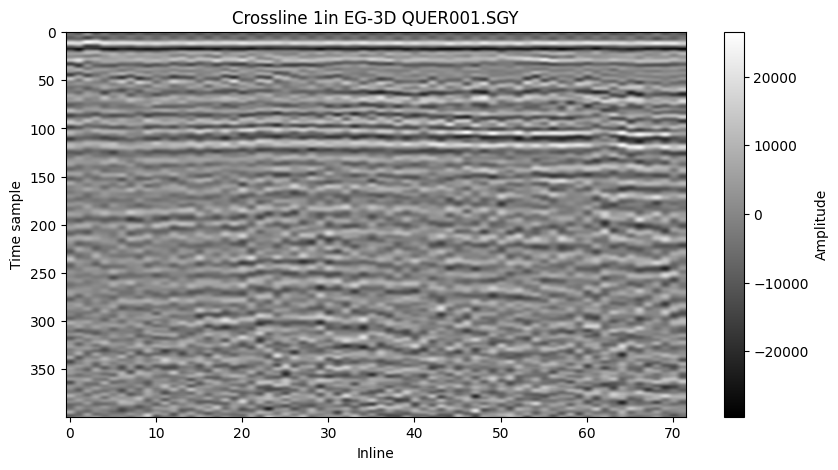

In [8]:
dk1.plot_crossline_cut_raw(df1, 1)
dk2.plot_crossline_cut_raw(df2, 1)

### Time slice Plot

This is the same Plot as in the Notebook **Analyzing the Data**. This plots the complete Grid from a top down view. This is a sphere threw time points which means a cut threw one point in time.

**Please Note that it is only one timeslice**

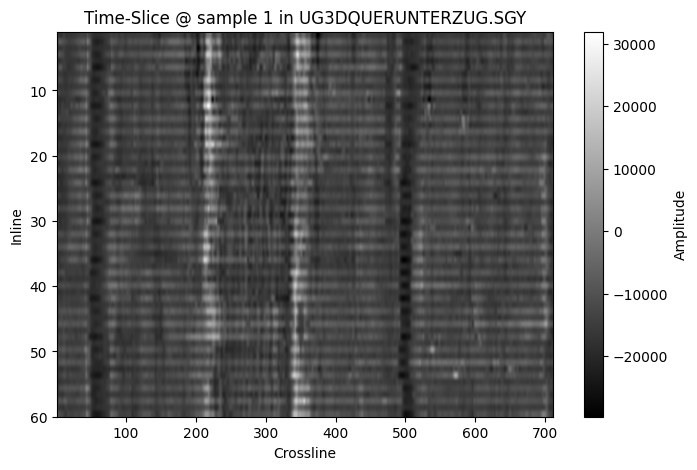

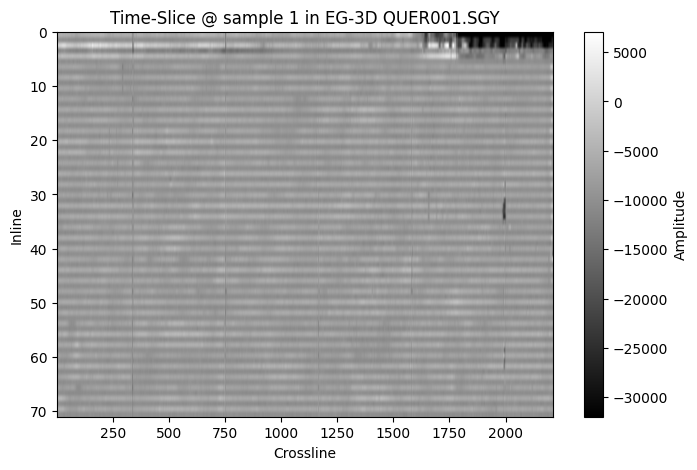

In [9]:
dk1.plot_timeslice_cut_raw(df1, 1)
dk2.plot_timeslice_cut_raw(df2 ,1)

So for the further steps in **Chapter 1** the focus is on the the inline Plots because there is much more density. Second reason is strategy based to focus on inline plots. below there is a table which shows the density

In [5]:
import pandas as pd
# here we compare de density from Inline and crossline Plots by simple plot the inline X Crossline and Crossline X inline
inlinenr = 1
crosslinenr = 1

#Inline cut density
sub_file1_in = df1[df1["inline"] == inlinenr].sort_values("crossline")
sub_file2_in = df2[df2["inline"] == inlinenr].sort_values("crossline")

#crossline cut density
sub_file1_cr = df1[df1["crossline"] == crosslinenr].sort_values("inline")
sub_file2_cr = df2[df2["crossline"] == crosslinenr].sort_values("inline")



d = {"Datasource": ["file1", "file2", "file1", "file2"], 
     "plottype": ["inline cut", "inline cut", "crossline cut", "crossline cut"], 
     "Spherenr": [inlinenr, inlinenr, crosslinenr, crosslinenr],
     "traces for cut": [len(sub_file1_in), len(sub_file2_in), len(sub_file1_cr), len(sub_file2_cr)]}

df_density = pd.DataFrame(d)

df_density



,Datasource,plottype,Spherenr,traces for cut
0,file1,inline cut,1,711
1,file2,inline cut,1,2211
2,file1,crossline cut,1,60
3,file2,crossline cut,1,72


### Chapter 2: Create multiple images out of Our given Data

The Code for that ist pretty straightforward. Because it is basically a plot without the axis description and titles so the full Plot is the radargramm.

First it is done on one inline cut.

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
inline_nr = 1
sub = df1[df1["inline"] == inline_nr].sort_values("crossline")
radar_img = np.vstack(sub["Amplitude"].values).T  # (samples x traces)
plt.imsave("inline_036.png", radar_img, cmap="gray")
plt.close()



Next step is to implement a function to create images for a whole Dataset with options to chosse between inline, crossline and time slice.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import segyio

def create_train_images(df, file, inline:bool = False, crossline:bool = False, timeslice:bool= False):
    
    outdir = TRAIN_DIR
    filename = df["filename"].iloc[0]

    if inline:
        inlines = sorted(df["inline"].unique())
        for inline_nr in inlines:
            sub = df[df["inline"] == inline_nr].sort_values("crossline")
            img = np.vstack(sub["Amplitude"].values).T
            out_path = os.path.join(outdir, f"{filename}_inline_{inline_nr}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {inline_nr} images to {out_path}")

    if crossline:
        crosslines = sorted(df["crossline"].unique())
        for crossline_nr in crosslines:
            sub = df[df["crossline"] == crossline_nr].sort_values("inline")
            img = np.vstack(sub["Amplitude"].values).T
            out_path = os.path.join(outdir, f"{filename}_crossline_{crossline_nr}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {crossline_nr} images to {out_path}")

    if timeslice:

        bin_header = dict(file.bin)
        bin_header_dict = dict(bin_header)
        n_samples = int(bin_header_dict[segyio.BinField.Samples])

        inlines = np.sort(df["inline"].unique())
        crosslines = np.sort(df["crossline"].unique())
        

        il_map = {v:i for i,v in enumerate(inlines)}
        cl_map = {v:i for i,v in enumerate(crosslines)}

        for sample_index in range(n_samples):
            mat = np.full((len(inlines), len(crosslines)), np.nan)

            for _,row in df.iterrows():
                i = il_map[row["inline"]]
                j = cl_map[row["crossline"]]
                mat[i, j] = row["Amplitude"][sample_index]
        
            img = np.nan_to_num(mat)
            out_path=os.path.join(outdir, f"{filename}_timeslice_{sample_index}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {sample_index} images to {out_path}")






This function can now be used for creating a complete daataset for a YOLO Model for annotating. Take in mind to leave some images for validation and testing.

- Here the inline_cuts are taken as images.

In [5]:
create_train_images(df1, file1, inline=True)

saved 60 images to c:\vscode\PAINDGPR\Data\train\UG3DQUERUNTERZUG.SGY_inline_60.png


In [ ]:
create_train_images(df2, file2, inline=True)

saved 71 images to c:\pythonad\PAINDHS25\PAINDGPR\Data\Train\EG-3D QUER001.SGY_inline_71.png


## Chapter 3: Normalize the Series of Images

So for ML Workflows its best preactize to normalize the Data because then the data is on the same scale. So here comes YOLO in handy because it does the this Job in the training process. More details you can find in the Documentation of this work on how Yolo does it and which methods are used. 

## Chapter 4: Annotating/Labeling the Data

Annotate the images is a job which is used to mark the regions of interest and add labels to it. For Annotating Roboflow is used which then also makes directly a train/valid/test split https://roboflow.com/